In [682]:
import pandas as pd 
import numpy as np
import re
import seaborn as sns
from nltk.corpus import words
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import warnings
from sklearn.exceptions import DataConversionWarning
from pandas.core.common import SettingWithCopyWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=SettingWithCopyWarning)

In [685]:
# This function will clean the text of email bodies by: 1. removing numbers, 
# 2. keeping only words longer than 4 letters. Ensuring each word is 
# part of the NLTK english language corpus led to exponential runtime.
def text_cleaner(string):
    split_words = re.findall("[^\d_\W]+", string)
    split_words = [word for word in split_words if len(word) > 4]
    # split_words = [word for word in split_words if word in words.words()]
    return " ".join(split_words)

# Returns 1 if the date inputted is during a school month (Jan-Apr, Sept-Dec), and 0 otherwise.
def in_school_year(date):
    month = int(re.findall(".+?(?=/)", date)[0])
    school_months = [1, 2, 3, 4, 9, 10, 11, 12]
    if month > 0 and month < 13:
        if month in school_months:
            return 1
        else:
            return 0
    else:
        return None
    
# Beautiful confusion matrix plotter from the Data 100 Berkeley textbook:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    import itertools
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)

In [698]:
# Read in and view raw input file
data = pd.read_csv("emails_as_csv_3367.csv")
data

,From,To,Subject,Date & Time Received,PDF Email Body Link,Email Text,Related
0,mail-noreply@google.com,rachitpareek@berkeley.edu,"The best of Gmail, wherever you are",5/1/18,https://drive.google.com/a/berkeley.edu/file/d...,Hi Rachit\n\nGet the official Gmail app\n\nThe...,0.0
1,mail-noreply@google.com,rachitpareek@berkeley.edu,Tips for using your new inbox,5/1/18,https://drive.google.com/a/berkeley.edu/file/d...,Hi Rachit\n\nWelcome to your Gmail inbox\n\nSa...,0.0
2,calmessages@berkeley.edu,calmessages_communication@lists.berkeley.edu,Report of the Free Speech Commission,5/2/18,https://drive.google.com/a/berkeley.edu/file/d...,"Dear campus community,\n\nI am delighted to sh...",0.0
3,shipcomms@berkeley.edu,rachitpareek@berkeley.edu,Fall 2018 SHIP Benefits and Waiver Info,5/3/18,https://drive.google.com/a/berkeley.edu/file/d...,"As a non-academic condition of enrollment, you...",0.0
4,orres@berkeley.edu,rachitpareek@berkeley.edu,California Residence for Tuition Purposes,5/3/18,https://drive.google.com/a/berkeley.edu/file/d...,"May 3, 2018\nRE: California R...",0.0
...,...,...,...,...,...,...,...
9645,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9646,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9647,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9648,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [699]:
# Basic pre-processing: 
# 1. Select only relevant columns.
data = data[["Date & Time Received", "From", "Subject", "Email Text", "Related"]].dropna().reset_index()
# 2. Use regex to help extract the sender domain from the emails.
data["From"] = data["From"].apply((lambda x: re.findall("(?<=@)[^.]+(?=\.)", x)[0]))
# 3. Clean email subject and body text using function defined above. 
data["Email Text"] = data["Email Text"].apply(text_cleaner)
data["Subject"] = data["Subject"].apply(text_cleaner)
print(str(round(data["Related"].sum()*100/len(data), 2)) + "% of the inputted emails are indicated to be truly internship-related.")
data

12.72% of the inputted emails are indicated to be truly internship-related.


,index,Date & Time Received,From,Subject,Email Text,Related
0,0,5/1/18,google,Gmail wherever,Rachit official Gmail features Gmail available...,0.0
1,1,5/1/18,google,using inbox,Rachit Welcome Gmail inbox everything storage ...,0.0
2,2,5/2/18,berkeley,Report Speech Commission,campus community delighted share report Speech...,0.0
3,3,5/3/18,berkeley,Benefits Waiver,academic condition enrollment medical insuranc...,0.0
4,4,5/3/18,berkeley,California Residence Tuition Purposes,California Residence Tuition Purposes Semester...,0.0
...,...,...,...,...,...,...
3352,3362,3/23/19,gradescope,Midterm Spring graded,Rachit Pareek Midterm Spring graded access gra...,0.0
3353,3363,3/24/19,linkedin,Rachit please LinkedIn network,Rachit LinkedIn network LinkedIn Rachit Pareek...,0.0
3354,3364,3/24/19,piazza,Daily Digest Piazza,Daily Digest Structure Interpretation Computer...,0.0
3355,3365,3/24/19,zipcar,first Ziptrip always remember,upcoming Ziptrip Honda Odyssey Velez STARTS Mi...,0.0


In [688]:
top_senders = data["From"].value_counts().to_frame().head(15).rename(columns={"From": "Counts"})
top_senders

,Counts
berkeley,836
piazza,338
notifications,206
instructure,199
gmail,186
haas,174
linkedin,139
mail,98
box,64
ijet,57


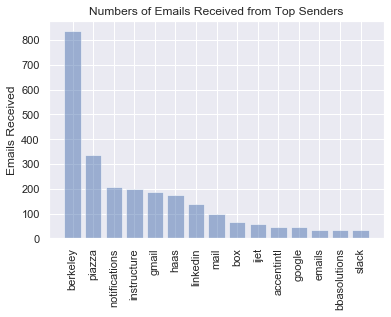

In [689]:
plt.bar(np.arange(len(top_senders)), np.array(top_senders["Counts"]), align='center', alpha=0.5)
plt.xticks(np.arange(len(top_senders)), np.array(top_senders.index), rotation='vertical')
plt.ylabel('Emails Received')
plt.title('Numbers of Emails Received from Top Senders')
plt.show()

In [690]:
# Use CountVectorizer to create a matrix representation of the words used across all emails:
cv = CountVectorizer(lowercase=True, stop_words='english', ngram_range = (1,1))
cv_word_counts = cv.fit_transform(data['Email Text'])

In [691]:
# Vectorized dictionary representation of each email:
cv_word_vectors = pd.DataFrame(cv_word_counts.todense(), columns=cv.get_feature_names())
cv_word_vectors.head()

,aaaaaaaaa,aaaaj,aabfsapiqar,aadhiti,aadhitighankota,aaditjoshi,aadkf,aakash,aaker,aalborg,...,õãêvõ,üêîäãêì,國立臺灣海洋大學,ﬁlled,ﬁnally,ﬁnished,ﬁrmly,ﬁtted,ﬂoors,𝗾𝘂𝗲𝘀𝘁𝗶𝗼𝗻
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [692]:
# Use TfidfVectorizer to create a matrix representation of the words used across all emails:
tv = TfidfVectorizer(lowercase=True, stop_words='english', ngram_range = (1,1))
tv_word_counts = tv.fit_transform(data['Email Text'])

In [693]:
# Vectorized dictionary representation of each email:
tv_word_vectors = pd.DataFrame(tv_word_counts.todense(), columns=tv.get_feature_names())
tv_word_vectors.head()

,aaaaaaaaa,aaaaj,aabfsapiqar,aadhiti,aadhitighankota,aaditjoshi,aadkf,aakash,aaker,aalborg,...,õãêvõ,üêîäãêì,國立臺灣海洋大學,ﬁlled,ﬁnally,ﬁnished,ﬁrmly,ﬁtted,ﬂoors,𝗾𝘂𝗲𝘀𝘁𝗶𝗼𝗻
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


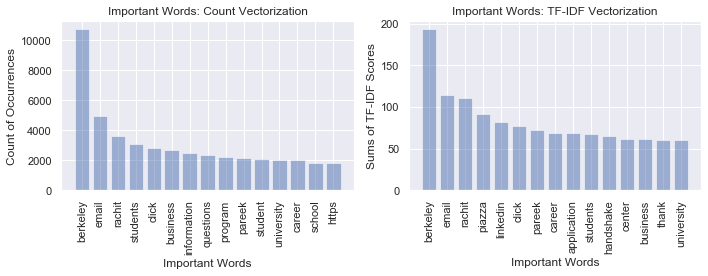

In [694]:
# Because the matrices are sparse, we can't interpret much from them. Let's visualize which words are the most 
# common have the most importance under both vectorization schemes:
cv_sums = (cv_word_vectors
           .sum(axis = 0, skipna = True)
           .to_frame()
           .rename(columns={0: "Sum of Counts"})
           .sort_values(by=["Sum of Counts"], ascending=False))
tv_sums = (tv_word_vectors
           .sum(axis = 0, skipna = True)
           .to_frame()
           .rename(columns={0: "Sum of Scores"})
           .sort_values(by=["Sum of Scores"], ascending=False))
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.bar(np.arange(len(cv_sums.head(15))), np.array(cv_sums.head(15)["Sum of Counts"]), align='center', alpha=0.5)
plt.xticks(np.arange(len(cv_sums.head(15))), np.array(cv_sums.head(15).index), rotation='vertical')
plt.xlabel('Important Words')
plt.ylabel('Count of Occurrences')
plt.title('Important Words: Count Vectorization')

plt.subplot(122)
plt.bar(np.arange(len(tv_sums.head(15))), np.array(tv_sums.head(15)["Sum of Scores"]), align='center', alpha=0.5)
plt.xticks(np.arange(len(tv_sums.head(15))), np.array(tv_sums.head(15).index), rotation='vertical')
plt.xlabel('Important Words')
plt.ylabel('Sums of TF-IDF Scores')
plt.title('Important Words: TF-IDF Vectorization')

plt.tight_layout();

In [701]:
# Let's do some feature engineering:
# 1. Add a few feature that indicate 1 if the email was sent during a school month (Jan-Apr, Sept-Dec), and 0 otherwise.
data["In School Year"] = data["Date & Time Received"].apply(in_school_year)
# 2. Add a few feature that shows the length of the email, normalizing by the average length of a word in the email.
data["Length"] = data["Email Text"].apply(lambda string: np.mean([len(i) for i in string.split(" ")]))
# 3. Could add vectorized representations of sender (or sender categories).
# Rename the final column
data = data[["From", "Subject", "Email Text", "In School Year", "Length", "Related"]].rename(columns={"Related": "Internship-Related"})
data

,From,Subject,Email Text,In School Year,Length,Internship-Related
0,google,Gmail wherever,Rachit official Gmail features Gmail available...,0,6.782609,0.0
1,google,using inbox,Rachit Welcome Gmail inbox everything storage ...,0,6.513514,0.0
2,berkeley,Report Speech Commission,campus community delighted share report Speech...,0,7.710000,0.0
3,berkeley,Benefits Waiver,academic condition enrollment medical insuranc...,0,7.591667,0.0
4,berkeley,California Residence Tuition Purposes,California Residence Tuition Purposes Semester...,0,7.695122,0.0
...,...,...,...,...,...,...
3352,gradescope,Midterm Spring graded,Rachit Pareek Midterm Spring graded access gra...,1,7.000000,0.0
3353,linkedin,Rachit please LinkedIn network,Rachit LinkedIn network LinkedIn Rachit Pareek...,1,7.472973,0.0
3354,piazza,Daily Digest Piazza,Daily Digest Structure Interpretation Computer...,1,6.950777,0.0
3355,zipcar,first Ziptrip always remember,upcoming Ziptrip Honda Odyssey Velez STARTS Mi...,1,6.640719,0.0


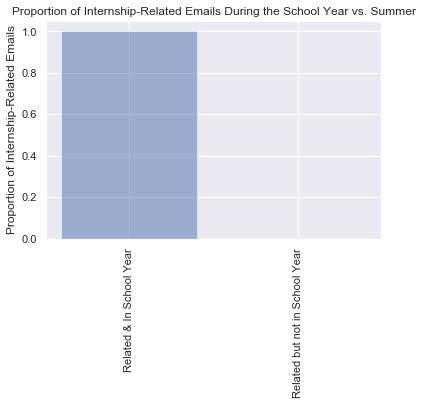

In [679]:
# This visualization seems to show that there's a strong connection between whether the email was sent during a school
# month and whether it was an internship-related email. The grind really concentrates itself in school months, and
# it would be odd, after all, to already be searching for another internship while working another one during the summer!
both = len(data[(data["In School Year"] > 0) & (data["Internship-Related"] > 0)])/len(data[(data["Internship-Related"] > 0)])
summer_internship = len(data[(data["In School Year"] == 0) & (data["Internship-Related"] > 0)])//len(data[(data["Internship-Related"] > 0)])
plt.bar(np.arange(2), [both, summer_internship], align='center', alpha=0.5)
plt.xticks(np.arange(2), 
           ["Related & In School Year", "Related but not in School Year"],
           rotation='vertical')
plt.ylabel('Proportion of Internship-Related Emails')
plt.title('Proportion of Internship-Related Emails During the School Year vs. Summer')
plt.show()

In [744]:
# Let's created a dataframe we can use for modeling, adding in the TF-IDF vector representations for the top 15 terms
# per email, and dropping unneeded columns. 
modeling_data = tv_word_vectors[np.array(tv_sums.head(15).index)]
modeling_data["In School Year"] = data["In School Year"]
modeling_data["Length"] = data["Length"]
modeling_data

,berkeley,email,rachit,piazza,linkedin,click,pareek,career,application,students,handshake,center,business,thank,university,In School Year,Length
0,0.000000,0.000000,0.073755,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0,6.782609
1,0.000000,0.025391,0.035457,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0,6.513514
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.037253,0.0,0.0,0.0,0.000000,0.000000,0,7.710000
3,0.103296,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.168678,0.0,0.0,0.0,0.000000,0.059322,0,7.591667
4,0.108776,0.000000,0.038873,0.000000,0.000000,0.000000,0.047763,0.0,0.0,0.044407,0.0,0.0,0.0,0.000000,0.000000,0,7.695122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3352,0.046616,0.000000,0.066637,0.110807,0.000000,0.000000,0.081876,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,1,7.000000
3353,0.025042,0.102539,0.143191,0.000000,0.579168,0.000000,0.087968,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,1,7.472973
3354,0.056108,0.080409,0.000000,0.106695,0.000000,0.061015,0.000000,0.0,0.0,0.128271,0.0,0.0,0.0,0.037474,0.016111,1,6.950777
3355,0.000000,0.038892,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,1,6.640719


In [745]:
# Let's first split the data into a training and test set. 
# We should also do validation, but let's hold off on that for a second.
#TODO: add comment, also should be doing all analysis above only on X_train
X_train, X_test, y_train, y_test = train_test_split(modeling_data,
                                                    data["Internship-Related"].to_frame(),
                                                    test_size=0.2,
                                                    random_state=42)
print(f'Number of features: {len(X_train.columns)}')
print(f'Training set size: {len(y_train)}')
print(f'Test set size: {len(y_test)}')

Number of features: 17
Training set size: 2685
Test set size: 672


In [746]:
#then fitting
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)
logistic_model.coef_

array([[-4.30376896, -0.14353358,  3.29492006, -1.56197943, -2.47157597,
        -0.12215105,  1.47310729,  0.57607178,  6.28092976, -1.66654234,
         2.26330877,  3.91548621, -0.17434615,  2.86639655, -0.79406598,
         2.74518626,  1.08032571]])

In [747]:
logistic_model.score(X_test, y_test)

0.9241071428571429

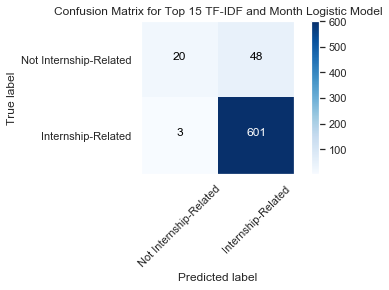

In [748]:
#confusion matrix to analyze
class_names = ["Not Internship-Related", "Internship-Related"]
conf_mat = confusion_matrix(y_test, logistic_model.predict(X_test), labels=[1, 0])
plot_confusion_matrix(conf_mat, classes=class_names, title='Confusion Matrix for Top 15 TF-IDF and Month Logistic Model')

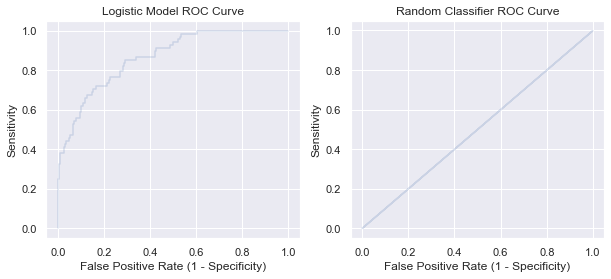

In [749]:
logistic_model_probabilities = logistic_model.predict_proba(X_test)[:, 1]
false_positive_rate_values, sensitivity_values, thresholds = roc_curve(y_test, logistic_model_probabilities, pos_label=1)

plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.step(false_positive_rate_values, sensitivity_values, color='b', alpha=0.2,
         where='post')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('Sensitivity')
plt.title('Logistic Model ROC Curve')

plt.subplot(122)
plt.step(np.arange(0, 1, 0.001), np.arange(0, 1, 0.001), color='b', alpha=0.2,
         where='post')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('Sensitivity')
plt.title('Random Classifier ROC Curve')
plt.show();

In [750]:
roc_auc_score(y_test, logistic_model_probabilities)

0.864993182703545

# TODO:
- vectorized repr of senders in feature engineering
- package up the modeling so i can run it with many numbers of top words (and cv vs tv)
- run and graph these scores and aucs, along with runtimes (see txtbk)